In [38]:
!pip install -e .

Obtaining file:///C:/Users/ericf/Github/ukko
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for ukko (pyproject.toml): started
  Building editable for ukko (pyproject.toml): finished with status 'done'
  Created wheel for ukko: filename=ukko-0.1.0-py3-none-any.whl size=1091 sha256=03de1317c853b6ca16462018311d1ea0957dc6410713d06f45e2c00ac4bffdc6
  Stored in directory: C:\Users\ericf\AppData\Local\Temp\pip-ephem-wheel-cache

In [2]:
!pip install lifelines

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import math
import ukko 
import importlib
# For preprocessing
print("Loading sklearn")
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import pandas as pd
import numpy as np
print("Libraries loaded")


Loading sklearn
Libraries loaded


## Load an preprocess data

Notes: 
- OSS_status: 1 means death  
  `assign(OSS_status = lambda x: np.where( np.isnan(x["death_time"].astype("float")), 0, 1))`

In [2]:
#Load tidy data
print("Loading tidy data")
df_xy = pd.read_csv("data/df_xy_synth_v1.csv")

# create train, validation and test datasets: IMPUTE nan: -1
df_train = df_xy.fillna(-1)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

# Numerical feature columns for standardizer
cols_standardize = df_xy.iloc[:,3:].columns


#print("Loading torch")
#import torch # For building the networks 
#import torchtuples as tt # Some useful functionsci  swop

#print("Loading pycox")
# from pycox.models import LogisticHazard
# from pycox.models import PMF
#->from pycox.models import DeepHitSingle
#from pycox.models import CoxPH #CoxPH = DeepSurv
#from pycox.evaluation import EvalSurv

#cols_standardize = df_x.columns

cols_standardize = df_xy.iloc[:,3:].columns
standardize = [([col], StandardScaler()) for col in cols_standardize]

x_mapper = DataFrameMapper(standardize)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
df_xy

print(f"Original data: {df_xy.shape}, type: {type(df_xy)}")
mycols = df_xy.columns[:4].tolist() + ['...'] + df_xy.columns[-2:].tolist()
print(f"      Columns: {mycols}")

print("")
print(f"Training data:   {x_train.shape[0]}, type: {type(x_train)}")
print(f"Test data:       {x_test.shape[0]}")
print(f"Validation data: {x_val.shape[0]}")


Loading tidy data
Original data: (1000, 273), type: <class 'pandas.core.frame.DataFrame'>
      Columns: ['person_id', 'OSS_days', 'OSS_status', "('Basophils/100 leukocytes in Blood', -5.0)", '...', "('Platelets [#/volume] in Blood', 20.0)", "('Platelets [#/volume] in Blood', 21.0)"]

Training data:   640, type: <class 'numpy.ndarray'>
Test data:       200
Validation data: 160


In [3]:
# Define function to convert df into 3-D numpy array
def convert_to_3d_df(df):

    # Convert column names to tuples, assuming this "('feature', timepoint)"
    columns = [eval(col) for col in df.columns]
    df.columns = columns
    
    # Extract unique features and timepoints
    features = sorted(list(set([col[0] for col in columns])))
    timepoints = sorted(list(set([col[1] for col in columns])))
    
    # Initialize a 3D numpy array
    n_rows = df.shape[0]
    n_features = len(features)
    n_timepoints = len(timepoints)
    data_3d = np.empty((n_rows, n_features, n_timepoints))
    data_3d.fill(np.nan)
    
    # Map feature names and timepoints to indices
    feature_indices = {feature: i for i, feature in enumerate(features)}
    timepoint_indices = {timepoint: i for i, timepoint in enumerate(timepoints)}
    
    # Fill the 3D array with data from the DataFrame
    for col in columns:
        feature, timepoint = col
        feature_idx = feature_indices[feature]
        timepoint_idx = timepoint_indices[timepoint]
        data_3d[:, feature_idx, timepoint_idx] = df[col]

    # Create a MultiIndex for the columns of the 3D DataFrame
    columns = pd.MultiIndex.from_product([features, timepoints], names=["Feature", "Timepoint"])
    
    # Create the 3D DataFrame
    df_multiindex = pd.DataFrame(data_3d.reshape(n_rows, -1), columns=columns)
    
    return df_multiindex, data_3d

# Example usage
data = {
    "('Basophils/100 leukocytes in Blood', -5.0)": [1, 2, 3],
    "('Basophils/100 leukocytes in Blood', 0.0)": [4, 5, 6],
    "('Platelets [#/volume] in Blood', -5.0)": [7, 8, 9],
    "('Platelets [#/volume] in Blood', 21.0)": [10, 11, 12]
}
df = pd.DataFrame(data)
df_multiindex, data_3d = convert_to_3d_df(df)

print("Test:")
display(df)

print('')
print('Multiindex df:')
print(df_multiindex.shape)
display(df_multiindex)

print(df_multiindex)


print('')
print('3D array [numpy]')
print(data_3d.shape, type(data_3d))
display(data_3d)


Test:


,"(Basophils/100 leukocytes in Blood, -5.0)","(Basophils/100 leukocytes in Blood, 0.0)","(Platelets [#/volume] in Blood, -5.0)","(Platelets [#/volume] in Blood, 21.0)"
0,1,4,7,10
1,2,5,8,11
2,3,6,9,12



Multiindex df:
(3, 6)


Feature   Basophils/100 leukocytes in Blood              \
Timepoint                             -5.0   0.0   21.0   
0                                       1.0   4.0   NaN   
1                                       2.0   5.0   NaN   
2                                       3.0   6.0   NaN   

Feature   Platelets [#/volume] in Blood              
Timepoint                         -5.0   0.0   21.0  
0                                   7.0   NaN  10.0  
1                                   8.0   NaN  11.0  
2                                   9.0   NaN  12.0

Feature   Basophils/100 leukocytes in Blood              \
Timepoint                             -5.0   0.0   21.0   
0                                       1.0   4.0   NaN   
1                                       2.0   5.0   NaN   
2                                       3.0   6.0   NaN   

Feature   Platelets [#/volume] in Blood              
Timepoint                         -5.0   0.0   21.0  
0                                   7.0   NaN  10.0  
1                                   8.0   NaN  11.0  
2                                   9.0   NaN  12.0  

3D array [numpy]
(3, 2, 3) <class 'numpy.ndarray'>


array([[[ 1.,  4., nan],
        [ 7., nan, 10.]],

       [[ 2.,  5., nan],
        [ 8., nan, 11.]],

       [[ 3.,  6., nan],
        [ 9., nan, 12.]]])

In [4]:
# Convert AML data to multiindex df
df_x, data_3d = convert_to_3d_df(df_xy.iloc[:,3:].fillna(-1))
df_y = df_xy.iloc[:,:3]
display(df_x)
display(df_y)

Feature   Basophils/100 leukocytes in Blood                                    \
Timepoint                             -5.0  -4.0  -3.0  -2.0  -1.0       0.0    
0                                      -1.0  -1.0  -1.0  -1.0  -1.0  0.850735   
1                                       2.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
2                                      -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
3                                      -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
4                                      -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
..                                      ...   ...   ...   ...   ...       ...   
995                                    -1.0  -1.0  -1.0  -1.0  -1.0  0.365545   
996                                    -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
997                                    -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
998                                    -1.0  -1.0  -1.0  -1.0  -1.0  0.714543   
999                                    -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   

Feature                            ... Platelets [#/volume] in Blood  \
Timepoint  1.0   2.0   3.0   4.0   ...                          12.0   
0          -1.0  -1.0  -1.0  -1.0  ...                     35.267531   
1          -1.0   0.8   0.6  -1.0  ...                     17.644103   
2           0.9   0.2  -1.0  -1.0  ...                     33.075386   
3          -1.0  -1.0  -1.0  -1.0  ...                     19.108278   
4          -1.0  -1.0  -1.0  -1.0  ...                     27.111444   
..          ...   ...   ...   ...  ...                           ...   
995        -1.0  -1.0  -1.0  -1.0  ...                     32.470881   
996        -1.0  -1.0  -1.0  -1.0  ...                     74.535567   
997        -1.0  -1.0   0.0  -1.0  ...                     10.970071   
998        -1.0  -1.0  -1.0  -1.0  ...                     30.374466   
999        -1.0  -1.0  -1.0  -1.0  ...                     47.135066   

Feature                                                                      \
Timepoint       13.0       14.0       15.0       16.0       17.0       18.0   
0          21.842999  26.972079   6.470798  25.946376  35.851646  -1.000000   
1           5.856022  33.222468  30.042670  10.961655  16.626338  14.611647   
2          19.972356  -1.000000  10.159840   7.403816  32.169956  13.245301   
3          -1.000000  10.593051  -1.000000   2.842802  11.054564  -1.000000   
4           8.762440  22.310250  25.011994  18.616336   8.396031  11.796703   
..               ...        ...        ...        ...        ...        ...   
995        39.852095  45.119058  -1.000000  19.426973  -1.000000  15.334406   
996        32.166004  -1.000000  37.804129  -1.000000  40.128945  18.025300   
997        -1.000000  -1.000000   5.812085  51.490996  37.736588  20.504332   
998        -1.000000  10.356835  -1.000000   9.787053  -1.000000  50.671958   
999        50.443120   7.596205  58.148557  26.659284  -1.000000  24.875252   

Feature                                     
Timepoint       19.0       20.0       21.0  
0          -1.000000  -1.000000  -1.000000  
1           6.030153  27.483864  -1.000000  
2          18.461631  -1.000000   4.782206  
3          23.594939  27.795295  -1.000000  
4           1.913356   0.251289  -1.000000  
..               ...        ...        ...  
995        43.252142  30.149195  -1.000000  
996        -1.000000  50.305928  51.343236  
997        31.987580  22.532788  -1.000000  
998        45.541768  -1.000000  -1.000000  
999        35.821172  -1.000000  -1.000000  

[1000 rows x 270 columns]

,person_id,OSS_days,OSS_status
0,0,1101.0,1
1,1,532.0,1
2,2,985.0,0
3,3,90.0,1
4,4,1885.0,0
...,...,...,...
995,995,1835.0,0
996,996,941.0,0
997,997,2.0,1
998,998,77.0,0


In [5]:
# Add 2 year survival

def add_two_year_survival(df):
    # Define a function to determine 2-year survival status
    def survival_status(row):
        if pd.isna(row['OSS_days']) or pd.isna(row['OSS_status']):
            return np.nan
        elif row['OSS_days'] >= 730:
            # return 0 = alive if OSS is > years
            return 0 
        else:
            # for OSS < 2 years: return 1 = dead if status = 1 (dead), nan (cencored) otherwise 
            return 1 if row['OSS_status'] == 1 else np.nan
    
    # Apply the function to each row
    df['2_year_survival (1=death)'] = df.apply(survival_status, axis=1)
    return df

df_y = add_two_year_survival(df_y)
display(df_y)

# Tidy 2 year survival data (no nans):
nanrows = df_y['2_year_survival (1=death)'].isna()
df_x_2year = df_x[~nanrows]
df_y_2year = df_y[~nanrows]
data_3d_2year = data_3d[~nanrows,:,:]

#print(df_y[(df_y['OSS_days']<730) & (df_y['OSS_status']==0)]) # double ckeck
print(f"{df_x.shape[0] - df_x_2year.shape[0]} patients with < 2 year censoring removed")
print(f"{df_x_2year.shape[0]} patients remain for 2-year survival analysis")

,person_id,OSS_days,OSS_status,2_year_survival (1=death)
0,0,1101.0,1,0.0
1,1,532.0,1,1.0
2,2,985.0,0,0.0
3,3,90.0,1,1.0
4,4,1885.0,0,0.0
...,...,...,...,...
995,995,1835.0,0,0.0
996,996,941.0,0,0.0
997,997,2.0,1,1.0
998,998,77.0,0,NaN


243 patients with < 2 year censoring removed
757 patients remain for 2-year survival analysis


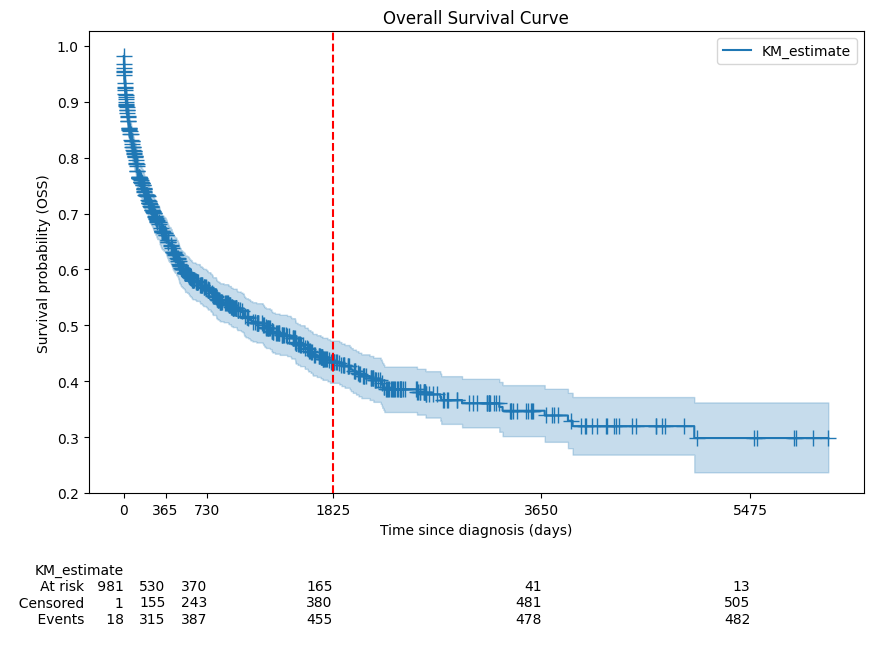

In [6]:
# Plot survival
import lifelines as ll
from lifelines import KaplanMeierFitter

import matplotlib.pyplot as plt
def plot_survival(df_y):
    # X-axis for plotting:
    timeline = [0, 365, 2*365, 5*365, 10*365, 15*365]
    # Create a KaplanMeierFitter instance
    kmf = KaplanMeierFitter()
    # Fit the data. 1 (death) = event observed
    kmf.fit(durations=df_y['OSS_days'], event_observed=df_y['OSS_status']==1)
    # Plot the survival curve
    plt.figure(figsize=(10, 6))
    ax = kmf.plot_survival_function(show_censors=True, ci_show=True, at_risk_counts=False)
    ll.plotting.add_at_risk_counts(kmf, ax=ax, xticks=timeline)
    # Indicate 2-year survival
    plt.axvline(x=5*365, color='r', linestyle='--', label='5-year mark')
    # Annotate
    plt.title('Overall Survival Curve')
    ax.xaxis.set_ticks(timeline)
    ax.set_xlabel('Time since diagnosis (days)')
    ax.set_ylabel('Survival probability (OSS)')
    #plt.ylabel('Survival Probability')
    #plt.grid(True)
    plt.show()

plot_survival(df_y)

In [7]:
# Use 2 year survival
# Dataloader from dataframe, multiindex

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, df_x, df_y): #data_tensor, labels_df):
        
        # Convert MultiIndex DataFrame to NumPy array
        # df should have multiindex features, timepoints
        n_features = len(df_x.columns.levels[0])
        n_timepoints = len(df_x.columns.levels[1])
        data_np = df_x.values.reshape(df_x.shape[0], n_features, n_timepoints)
        
        # Convert NumPy array to PyTorch tensor
        data_tensor = torch.tensor(data_np, dtype=torch.float32)
        
        # Keep column annotations
        self.features = df_x.columns.levels[0]
        self.timepoints = df_x.columns.levels[1]
        self.samples = df_x.index
        self.labelname = '2_year_survival (1=death)'
        
        self.data = data_tensor

        # Keep survival data
        self.df_x = df_x
        self.df_y = df_y
        
        # Labels are 2-year survival (0=alive, 1=death)
        # self.labels = df_y['2_year_survival (1=death)'].values
        # Convert labels to PyTorch tensor
        self.labels = torch.tensor(df_y['2_year_survival (1=death)'].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx].float() # Ensure features are float
        label =  self.labels[idx].long() # Ensure targets are long integers for classification
        return sample, label


# Split the data into training and remaining sets (80% train, 20% remaining)
X_train, X_remaining, y_train, y_remaining = train_test_split(df_x_2year, df_y_2year, test_size=0.2, random_state=42)

# Split the remaining data into validation and test sets (50% validation, 50% test of the remaining 20%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Print the shapes of the splits to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Create Dataset and DataLoader
# dataset = CustomDataset(df_x_2year, df_y_2year)
# dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
dataset_train = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset_train, batch_size=605, shuffle=True)
dataset_val = CustomDataset(X_val, y_val)
val_loader = DataLoader(dataset_val, batch_size=605, shuffle=False)
dataset_test = CustomDataset(X_test, y_test)
test_loader = DataLoader(dataset_test, batch_size=605, shuffle=False)


x,y = dataset_test[1]
print(x.shape)
print(y)

batch = next(iter(test_loader))
print(batch[0].shape)
print(batch[1].shape)

# Example usage
# if __name__ == "__main__":
#     for batch in dataloader:
#         data, labels = batch
#         print("Data:", data)
#         print("Labels:", labels)

Training set shape: (605, 270) (605, 4)
Validation set shape: (76, 270) (76, 4)
Test set shape: (76, 270) (76, 4)
torch.Size([10, 27])
tensor(0)
torch.Size([76, 10, 27])
torch.Size([76])


10
27
Epoch   1/200, Train Loss: 0.7067, Val Loss: 0.6884
Epoch  11/200, Train Loss: 0.6940, Val Loss: 0.6944
Epoch  21/200, Train Loss: 0.6942, Val Loss: 0.6924
Epoch  31/200, Train Loss: 0.6927, Val Loss: 0.6941
Epoch  41/200, Train Loss: 0.6925, Val Loss: 0.6952
Epoch  51/200, Train Loss: 0.6929, Val Loss: 0.6923
Epoch  61/200, Train Loss: 0.6936, Val Loss: 0.6930
Epoch  71/200, Train Loss: 0.6927, Val Loss: 0.6910
Epoch  81/200, Train Loss: 0.6884, Val Loss: 0.6902
Epoch  91/200, Train Loss: 0.6702, Val Loss: 0.6493
Epoch 101/200, Train Loss: 0.6586, Val Loss: 0.6439
Epoch 111/200, Train Loss: 0.6552, Val Loss: 0.6181
Epoch 121/200, Train Loss: 0.6639, Val Loss: 0.6192
Epoch 131/200, Train Loss: 0.6536, Val Loss: 0.6307
Epoch 141/200, Train Loss: 0.6579, Val Loss: 0.6280
Epoch 151/200, Train Loss: 0.6566, Val Loss: 0.6163
Epoch 161/200, Train Loss: 0.6529, Val Loss: 0.6144
Epoch 171/200, Train Loss: 0.6529, Val Loss: 0.6166
Epoch 181/200, Train Loss: 0.6510, Val Loss: 0.6161
Epoch 

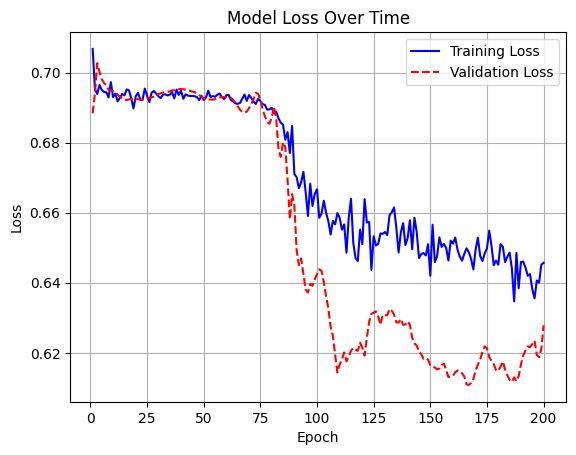

In [16]:
importlib.reload(ukko)
importlib.reload(ukko.data)
importlib.reload(ukko.core)
importlib.reload(ukko.test)

# Create dictionary to store metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

n_features = dataset_train.features.shape[0]
timepoints = dataset_train.timepoints.shape[0]
print(n_features)
print(timepoints)

# Quick data for testing
dataset_train = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True)

# Initialize model
# DualAttentionClassifier(self, n_features, time_steps, n_classes, d_model=128, n_heads=8, dropout=0.1)
model = ukko.core.DualAttentionClassifier1(
    n_features=n_features,
    time_steps=timepoints,
    n_labels=1,  # 2-year surival
    n_classes=2, # 2 classes: 0=alive, 1=death
    d_model=32,
    n_heads=4,
    dropout=0.2,
    n_modules=1
)

def train_sine_model(model, train_loader, val_loader, epochs=100, lr=0.001, device='cpu', verbose=True):
    model = model.to(device)
    model = model.float()
    #criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            #print(f"X: {x.shape}")
            #print(f"y: {y.shape}")
            #print(f"Type: {y.dtype}")
            y = y.long()  # Convert targets to long (required for CrossEntropyLoss)
                
            optimizer.zero_grad()
            output, _, _ = model(x)
            #print(f"Output: {output.shape}")
            #print(f"Type: {output.dtype}")
            
            # Squeeze n_labels dimension since we only have one label
            output = output.squeeze(1)  # Shape: [batch_size, n_classes]
           
            #loss = criterion(output, y[:, :, 0])  # Compare with first time step of prediction
            loss = criterion(output, y)  # y is only one timepoint 5 or 4 steps ahead
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.float().to(device), y.long().to(device)
                output, _, _ = model(x)     # Shape: [batch_size, n_labels, n_classes]
                # Becasue only 1 label:
                output = output.squeeze(1)  # Shape: [batch_size, n_classes]
                #val_loss += criterion(output, y[:, :, 0]).item()
                val_loss += criterion(output, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Log training progress:
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if verbose:
            if epoch%10==0:
                print(f"Epoch {epoch+1:3.0f}/{epochs}, Train Loss: {train_loss:1.4f}, Val Loss: {val_loss:1.4f}")
            #print(f"Train Loss: {train_loss:1.4f}")
            #print(f"Val Loss: {val_loss:1.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_sine_model.pt')

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_sine_model(model, train_loader, val_loader, epochs=200, device=device)
history1 = history

# Visualize training
ukko.core.plot_training_curves(
    train_losses = history['train_loss'], 
    val_losses   = history['val_loss'],
    figsize=(15, 5),
)

In [10]:
importlib.reload(ukko.core)
#help(ukko.core.DualAttentionClassifier1)

<module 'ukko.core' from '/users/ericfey1/github/ukko/src/ukko/core.py'>

In [ ]:
#Good model:
d_model=32,
n_heads=4,
dropout=0.2,

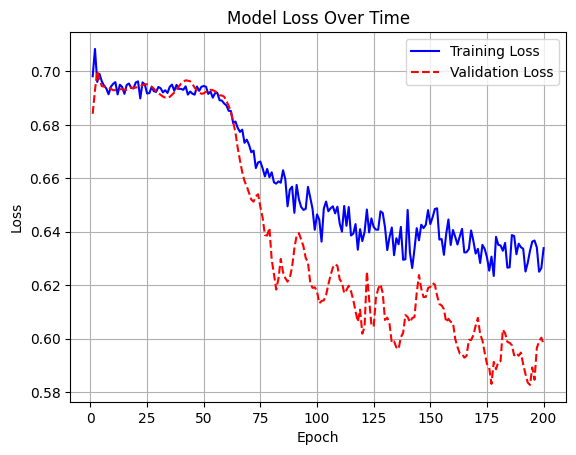

In [71]:
# Visualize training
ukko.core.plot_training_curves(
    train_losses = history['train_loss'], 
    val_losses   = history['val_loss'],
    figsize=(15, 5),
)


Validation Set Performance:


/tmp/ericfey1/27120789/ipykernel_629200/1362567618.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_sine_model.pt'))


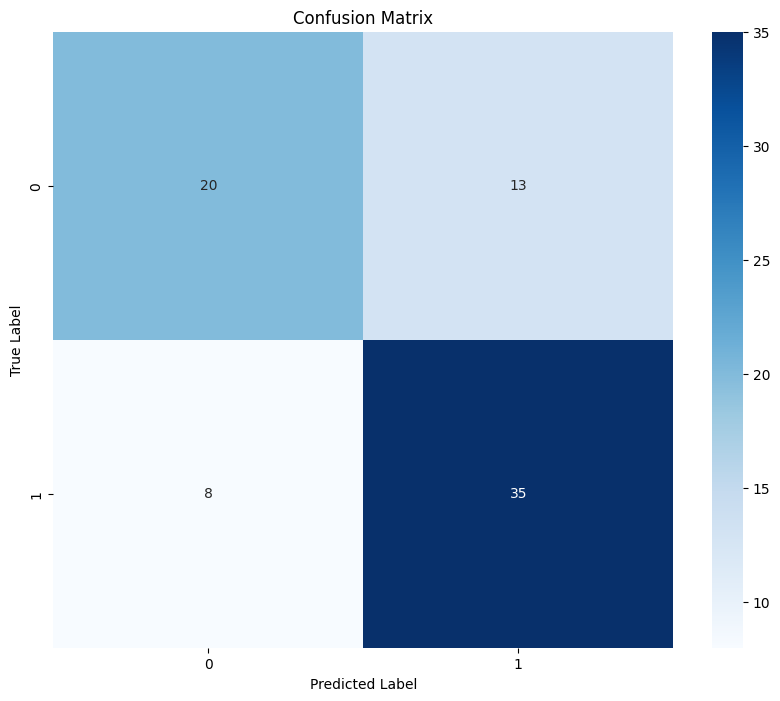


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        33
           1       0.73      0.81      0.77        43

    accuracy                           0.72        76
   macro avg       0.72      0.71      0.71        76
weighted avg       0.72      0.72      0.72        76



In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.float().to(device)
            y = y.long().to(device)
            
            outputs, _, _ = model(x)
            outputs = outputs.squeeze(1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    return cm

device = "cuda"

# Load the best model
best_model = model
best_model.load_state_dict(torch.load('best_sine_model.pt'))
best_model = best_model.to(device)

# Evaluate on validation set
print("Validation Set Performance:")
val_cm = evaluate_model(best_model, val_loader, device=device)